<a href="https://colab.research.google.com/github/msvt37/Project-2/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Evaluation of Multiple Trading Strategies for a single equity (LUV).  

The code below is a collection of strategies against the ticker (LUV) or Southwest airlines.  

In [1]:
import pandas as pd
import keras
import pandas.plotting
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pylab import mpl, plt
plt.style.use('seaborn')

In [3]:
!pip install yfinance
import yfinance as yf

In [4]:
#Defines the ticker symbols and dates to pull data for
symbols = ['LUV']
start = '2001-01-01'
end = '2021-06-03'

In [5]:
#create the DF and pull in only the Adjusted Close for specified ticker
df = pd.DataFrame()
for s in symbols:
    df[s] = yf.download(s,start,end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [6]:
#Column does not have a name, so name it
df.rename(columns={ df.columns[0] : 'Adj Close'}, inplace=True)

Simple Moving Averages smooth the price trends and remove noise from the series. When asset prices move over their SMA (cross-over), it may indicate a trading signal.  Using a shorter term MA with a longer term MA is known as a "golden cross".  Investors watch for shorter term to cross above the longer term for their buy signal. When the shorter term crosses under the longer term, it's a sell signal.

In [7]:
# Set the timeframe for the Simple Moving Averages (42 days and 252 days)
SMA1 = 42  
SMA2 = 252

In [8]:
# Create SMA columns and perform the calculations
df['SMA1'] = df['Adj Close'].rolling(SMA1).mean()  
df['SMA2'] = df['Adj Close'].rolling(SMA2).mean()

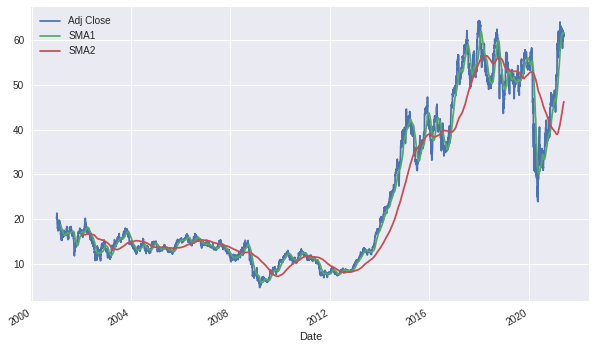

In [9]:
df.plot(figsize=(10, 6))

In [10]:
df.dropna(inplace=True)

In [11]:
# Check where the short term MA is greater than longe term MA, mark those with a 1 and others with -1
df['Position'] = np.where(df['SMA1'] > df['SMA2'], 1, -1)

In [12]:
df.head()

,Adj Close,SMA1,SMA2,Position
Date,,,,
2002-01-07,17.585379,17.019541,16.703195,1
2002-01-08,17.264807,17.055187,16.690709,1
2002-01-09,16.797701,17.069247,16.677823,1
2002-01-10,16.495453,17.077854,16.659162,1
2002-01-11,16.284790,17.092564,16.639302,1


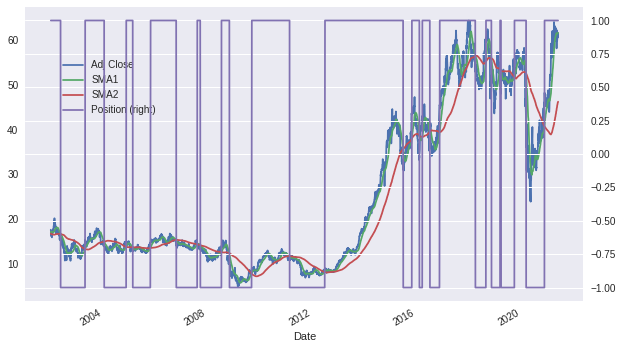

In [13]:
ax = df.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

Backtest the strategy.  Calculate the logs returns and then multiply by the postion.  Performance values show the return with SMA and holding long.

In [14]:
# Calculate the log returns for investment (benchmark)
df['Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

In [15]:
#
df['Strategy'] = df['Position'].shift(1) * df['Returns']

In [16]:
df.dropna(inplace=True)

In [17]:
# Sum of returns
np.exp(df[['Returns', 'Strategy']].sum())

Returns     3.461398
Strategy    0.769117
dtype: float64

In [18]:
# Calculate annualized volatility
df[['Returns', 'Strategy']].std() * 252 ** 0.

Returns     0.022206
Strategy    0.022208
dtype: float64

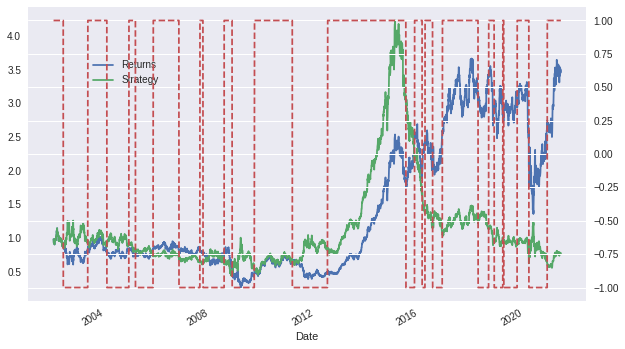

In [19]:
ax = df[['Returns', 'Strategy']].cumsum(
                 ).apply(np.exp).plot(figsize=(10, 6))
df['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

Linear OLS Regression using two features, lag 1 and lag 2 (two day and one day lags)


In [20]:
# create a copy of the adjusted closing prices in a new dataframe
data2 = df[['Adj Close']].copy()

In [21]:
# Calculate the log returns
data2['Returns'] = np.log(data2 / data2.shift(1))

In [22]:
data2.dropna(inplace=True)

In [23]:
# Establish direction of movement
data2['Direction'] = np.sign(data2['Returns']).astype(int)

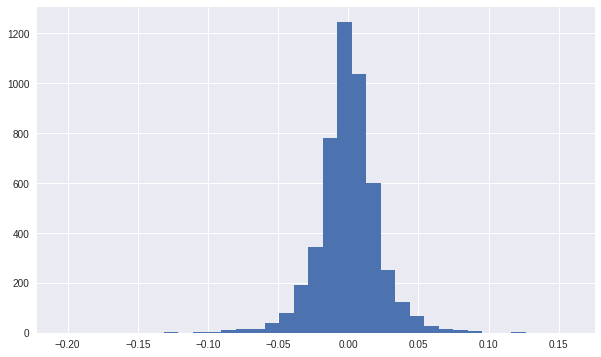

In [24]:
data2['Returns'].hist(bins=35, figsize=(10, 6))

In [25]:
lags = 2

In [26]:
# Function to create the lagged values for features
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['Returns'].shift(lag)
        cols.append(col)

In [27]:
# Call function
create_lags(data2)

In [28]:
data2.dropna(inplace=True)

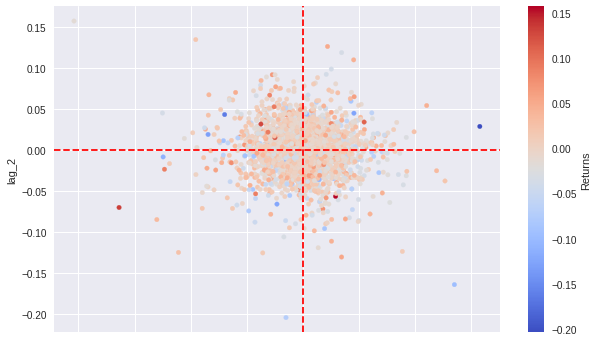

In [29]:
data2.plot.scatter(x='lag_1', y='lag_2', c='Returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--')

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
# Use linear regression model to predict movement 
model = LinearRegression()

In [32]:
data2['pos_ols_1'] = model.fit(data2[cols], data2['Returns']).predict(data2[cols])

data2['pos_ols_2'] = model.fit(data2[cols], data2['Direction']).predict(data2[cols])

In [33]:
data2[['pos_ols_1', 'pos_ols_2']] = np.where(
            data2[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [34]:
data2['strat_ols_1'] = data2['pos_ols_1'] * data2['Returns']

data2['strat_ols_2'] = data2['pos_ols_2'] * data2['Returns']

In [35]:
data2[['Returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

Returns         3.690108
strat_ols_1    92.992811
strat_ols_2    63.463025
dtype: float64

In [36]:
# Count number of correct and false predictions by strategy
(data2['Direction'] == data2['pos_ols_1']).value_counts()

True     2540
False    2341
dtype: int64

In [37]:
(data2['Direction'] == data2['pos_ols_2']).value_counts()

True     2532
False    2349
dtype: int64

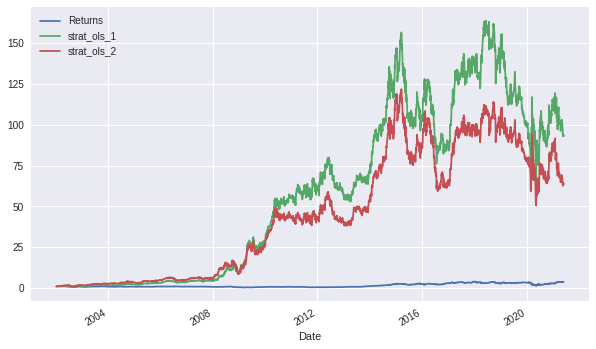

In [38]:
# Performance over time
data2[['Returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))

Facebook Prophet :  The code below is an attempt to use FB prophet for Time Series Forecasting.  (Needs more work and may scrap)

In [47]:
data3 = df[['Adj Close']].copy()

In [48]:
data3.reset_index(inplace=True)

In [49]:
data3

,Date,Adj Close
0,2002-01-08,17.264807
1,2002-01-09,16.797701
2,2002-01-10,16.495453
3,2002-01-11,16.284790
4,2002-01-14,16.174877
...,...,...
4879,2021-05-26,61.209999
4880,2021-05-27,61.730000
4881,2021-05-28,61.459999
4882,2021-06-01,61.349998


In [60]:
data3 = data3.rename(columns={'Date':'ds', 'Adj Close':'y'})

In [61]:
data3.shape

(4884, 2)

In [54]:
df_train = data3[['ds', 'y']].iloc[:2930]
df_predict = data3[['ds']]

In [55]:

from fbprophet import Prophet
# instantiate the model and set parameters
model = Prophet(
 interval_width=0.95,
 growth='linear',
 daily_seasonality=False,
 weekly_seasonality=True,
 yearly_seasonality=True,
 seasonality_mode='multiplicative'
)
# fit the model to historical data
model.fit(df_train)

In [56]:
forecast = model.predict(df_predict)

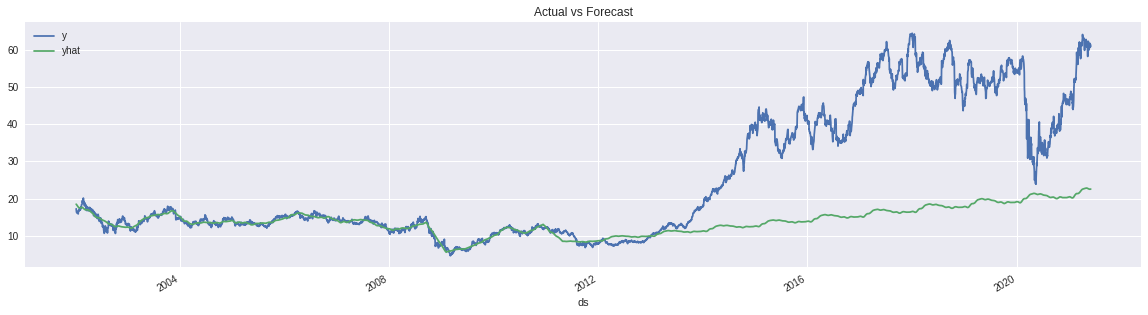

In [57]:
ax = (data3.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
forecast.plot(x='ds',y='yhat',figsize=(20,5),title='Actual vs Forecast', ax=ax)

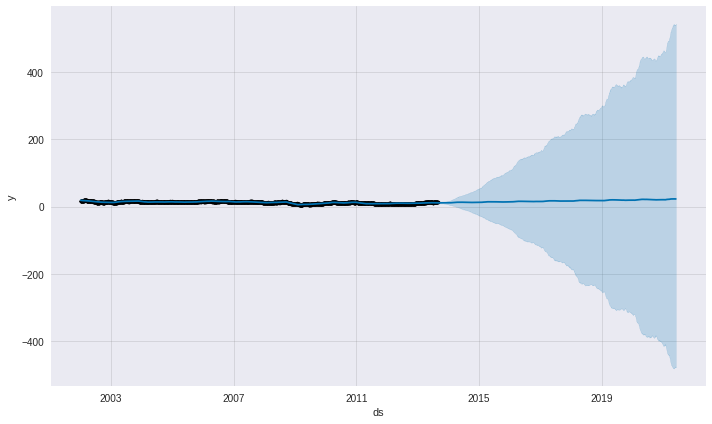

In [68]:
fig1 = model.plot(forecast, uncertainty=True)

In [63]:
model2 = Prophet(
 interval_width=0.95,
 growth='linear',
 daily_seasonality=False,
 weekly_seasonality=True,
 yearly_seasonality=True,
 seasonality_mode='multiplicative'
)
# fit the model to historical data
model2.fit(data3)

In [65]:
future_pd = model2.make_future_dataframe(
 periods=20,
 freq='d',
 include_history=True
)
# predict over the dataset
forecast_pd = model2.predict(future_pd)

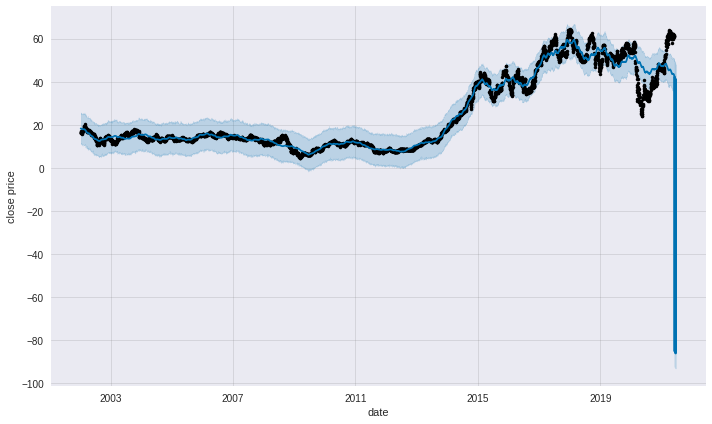

In [67]:
predict_fig = model2.plot(forecast_pd, xlabel='date', 
ylabel='close price')


Add Deep NN model here:  See Python for Algo Trading for references
